# Checking Python Version (Must be less than 3.10 to support tensorflow)

In [ ]:
!python --version

Python 3.11.12


# Install the used libraries

In [ ]:
!pip install datasets
!pip install tensorflow
!pip install contractions
!pip install textblob
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 18.6 MB/s eta 0:00:00


# Part 1 : Data Preprocessing and Baseline Modeling

### Loading the dataset

In [ ]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("cardiffnlp/tweet_eval", "sentiment")
train_data = dataset['train']
df = pd.DataFrame(train_data)

### Preprocessing the dataset

In [ ]:
import re
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from contractions import fix
# pip install textblob
from textblob import Word



# Download necessary resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

# Pre-compile regex patterns
URL_PATTERN = re.compile(r"http\S+")
USER_PATTERN = re.compile(r"@\w+")
HASHTAG_PATTERN = re.compile(r"#\w+")
SPECIAL_CHARS = re.compile(r"[^\w\s]")  # Removes punctuation, keeps digits
NUM_PATTERN = re.compile(r"\d+")
ELONGATED_PATTERN = re.compile(r'(.)\1{2,}', re.DOTALL)  # e.g., soooo → soo

# Initialize tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english')) - {'not', 'no', 'nor'}

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Expand contractions
    text = fix(text)

    # Convert to lowercase
    text = text.lower()

    # Remove URLs, user mentions, hashtags
    text = URL_PATTERN.sub('', text)
    text = USER_PATTERN.sub('', text)
    text = HASHTAG_PATTERN.sub('', text)

    # Demojize emojis (😊 -> :smile_face:)
    text = emoji.demojize(text)

    # Normalize elongated words
    text = ELONGATED_PATTERN.sub(r'\1\1', text)  # soooo → soo

    # Replace numbers with <NUM> token
    text = NUM_PATTERN.sub(' <NUM> ', text)

    # Remove special characters
    text = SPECIAL_CHARS.sub(' ', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Lemmatize and remove stopwords
    tokens = [
        lemmatizer.lemmatize(word) for word in tokens
        if word not in stop_words and len(word) > 2
    ]
    #tokens = [Word(word).correct() for word in tokens] will try it so slow.

    return " ".join(tokens)


df['clean_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### Exploratory data analysis (EDA)

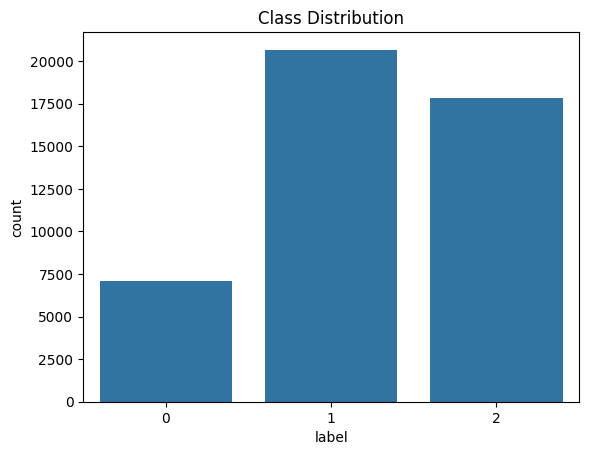

Most common words for label 0: [('NUM', 5547), ('not', 2282), ('may', 1574), ('tomorrow', 932), ('like', 599), ('going', 579), ('day', 498), ('get', 423), ('time', 388), ('want', 348)]
Most common words for label 1: [('NUM', 21581), ('tomorrow', 2942), ('may', 2903), ('not', 2853), ('going', 1634), ('day', 1485), ('night', 1330), ('sunday', 1235), ('friday', 1210), ('time', 1170)]
Most common words for label 2: [('NUM', 15269), ('tomorrow', 3530), ('day', 2270), ('may', 2205), ('not', 2132), ('going', 1657), ('see', 1576), ('night', 1509), ('friday', 1259), ('time', 1161)]


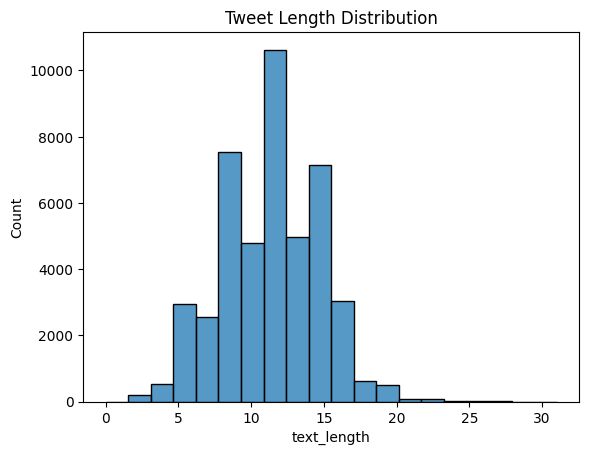

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Class distribution
sns.countplot(x=df['label'])
plt.title("Class Distribution")
plt.show()

# Most frequent words per class
for label in [0, 1, 2]:  # 0: Negative, 1: Neutral, 2: Positive
    words = " ".join(df[df['label'] == label]['clean_text']).split()
    common_words = Counter(words).most_common(10)
    print(f"Most common words for label {label}: {common_words}")

# Tweet length
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))
sns.histplot(df['text_length'], bins=20)
plt.title("Tweet Length Distribution")
plt.show()

### Tokenization and Padding

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

#splitting data
X_train, X_test, y_train, y_test = train_test_split(df['clean_text'], df['label'], test_size=0.2, random_state=42)

#tokenization
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

vocab_size = min(len(tokenizer.word_index) + 1, 10000)
embedding_dim = 100

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
lengths = [len(seq) for seq in tokenizer.texts_to_sequences(X_train)]
max_length = int(np.percentile(lengths, 90))  # use 90th percentile
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post')

#one hot labels
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

### RNN Based Model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 15, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,012,739 (3.86 MB)

 Trainable params: 1,012,739 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - accuracy: 0.4954 - loss: 0.9536 - val_accuracy: 0.5998 - val_loss: 0.8386
Epoch 2/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.7262 - loss: 0.6396 - val_accuracy: 0.6030 - val_loss: 0.8789
Epoch 3/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.8693 - loss: 0.3514 - val_accuracy: 0.5920 - val_loss: 1.0837
Epoch 4/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.9412 - loss: 0.1756 - val_accuracy: 0.5545 - val_loss: 1.3198
Epoch 5/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.9655 - loss: 0.1035 - val_accuracy: 0.5556 - val_loss: 1.5824
Epoch 6/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 13s 15ms/step - accuracy: 0.9766 - loss: 0.0680 - val_accuracy: 0.5423 - val_loss: 1.8781
Epoch 7/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - accuracy: 0.9812 - loss: 0.0571 - val_accuracy: 0.5590 - val_loss: 2.0559
Epoch 8/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.9825 - loss: 0.0494 - 

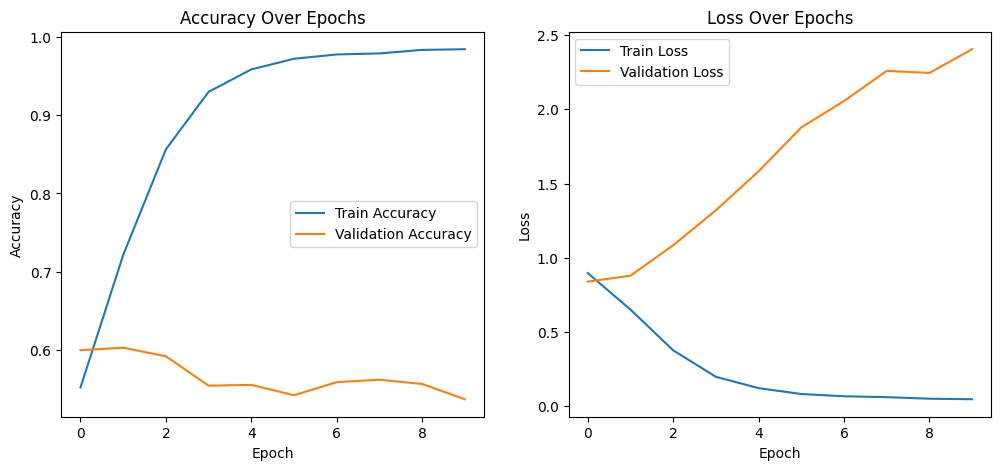

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


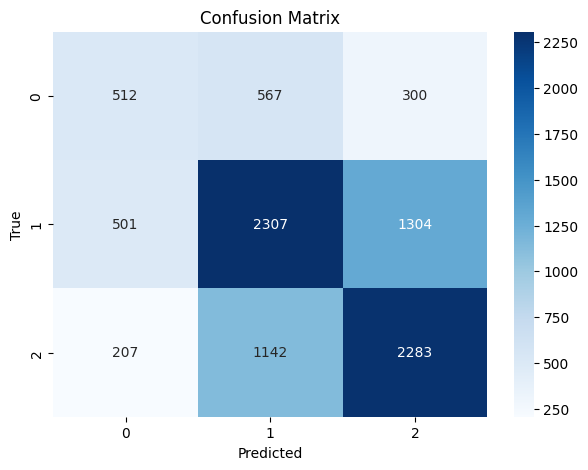

Classification Report:

              precision    recall  f1-score   support

           0     0.4197    0.3713    0.3940      1379
           1     0.5745    0.5610    0.5677      4112
           2     0.5873    0.6286    0.6073      3632

    accuracy                         0.5592      9123
   macro avg     0.5272    0.5203    0.5230      9123
weighted avg     0.5562    0.5592    0.5572      9123



In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Defining the RNN model
rnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    SimpleRNN(64),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Summary
rnn_model.build(input_shape=(None, max_length))
rnn_model.summary()

# Training the model
history = rnn_model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot Training Curves
plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Testing model
y_pred_probs = rnn_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))

### Feed Forward Based Model

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 15, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1500)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       192,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,200,579 (4.58 MB)

 Trainable params: 1,200,579 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.5336 - loss: 0.9249 - val_accuracy: 0.6328 - val_loss: 0.7871
Epoch 2/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.7845 - loss: 0.5135 - val_accuracy: 0.6036 - val_loss: 0.9053
Epoch 3/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.9345 - loss: 0.1818 - val_accuracy: 0.5768 - val_loss: 1.3883
Epoch 4/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9730 - loss: 0.0786 - val_accuracy: 0.5806 - val_loss: 1.9442
Epoch 5/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9856 - loss: 0.0432 - val_accuracy: 0.5612 - val_loss: 2.4154
Epoch 6/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9885 - loss: 0.0347 - val_accuracy: 0.5768 - val_loss: 2.8635
Epoch 7/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - accuracy: 0.9886 - loss: 0.0324 - val_accuracy: 0.5717 - val_loss: 2.8875
Epoch 8/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.9924 - loss: 0.0235 - 

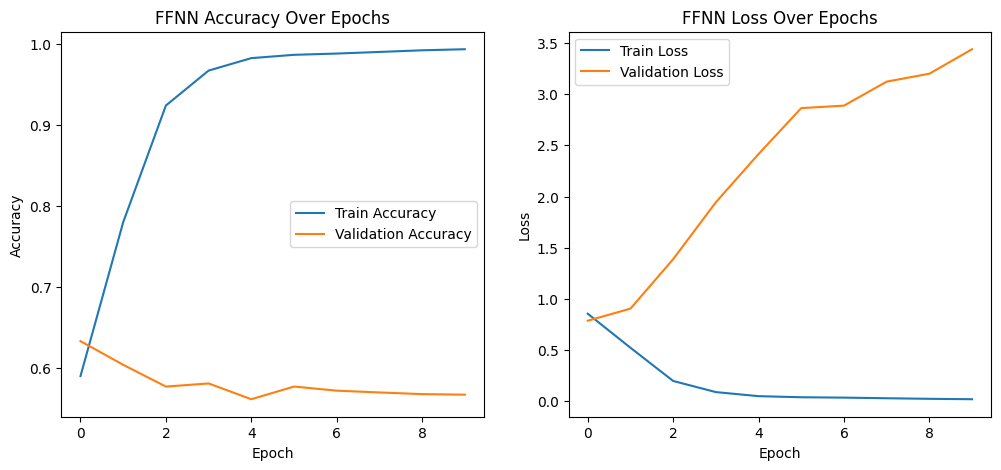

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


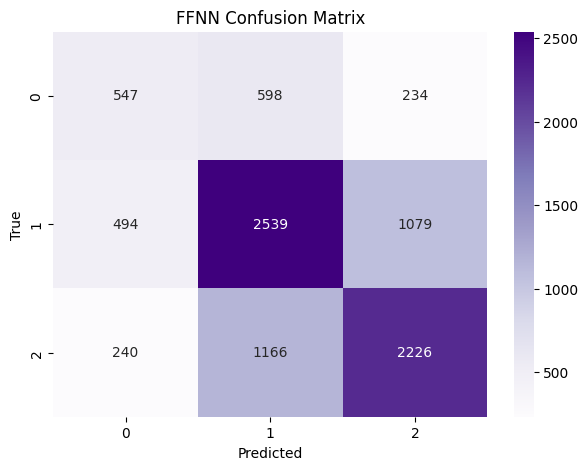

FFNN Classification Report:

              precision    recall  f1-score   support

           0     0.4270    0.3967    0.4113      1379
           1     0.5901    0.6175    0.6034      4112
           2     0.6290    0.6129    0.6208      3632

    accuracy                         0.5823      9123
   macro avg     0.5487    0.5423    0.5452      9123
weighted avg     0.5809    0.5823    0.5813      9123



In [ ]:
from tensorflow.keras.layers import Dense, Flatten, Embedding
from tensorflow.keras.models import Sequential
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Defining the Feed Forward model
ffnn_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    Flatten(),                             # Flatten the embeddings into a 1D vector
    Dense(128, activation='relu'),          # Hidden layer 1
    Dense(64, activation='relu'),           # Hidden layer 2 (optional but helps)
    Dense(3, activation='softmax')           # Output layer (3 classes)
])

ffnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Building the model
ffnn_model.build(input_shape=(None, max_length))
ffnn_model.summary()

# Training the model
history_ffnn = ffnn_model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot Training Curves
plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history_ffnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_ffnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('FFNN Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(history_ffnn.history['loss'], label='Train Loss')
plt.plot(history_ffnn.history['val_loss'], label='Validation Loss')
plt.title('FFNN Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Testing model
y_pred_probs_ffnn = ffnn_model.predict(X_test_pad)
y_pred_ffnn = np.argmax(y_pred_probs_ffnn, axis=1)
y_true_ffnn = np.argmax(y_test_cat, axis=1)

# Confusion Matrix
conf_mat_ffnn = confusion_matrix(y_true_ffnn, y_pred_ffnn)

plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_ffnn, annot=True, fmt='d', cmap='Purples')
plt.title('FFNN Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("FFNN Classification Report:\n")
print(classification_report(y_true_ffnn, y_pred_ffnn, digits=4))


### LSTM Based Model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 15, 100)        │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,044,419 (3.98 MB)

 Trainable params: 1,044,419 (3.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.5469 - loss: 0.9144 - val_accuracy: 0.6331 - val_loss: 0.7796
Epoch 2/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.7196 - loss: 0.6535 - val_accuracy: 0.6291 - val_loss: 0.7941
Epoch 3/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.7717 - loss: 0.5451 - val_accuracy: 0.6256 - val_loss: 0.8294
Epoch 4/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 19s 20ms/step - accuracy: 0.8100 - loss: 0.4463 - val_accuracy: 0.6031 - val_loss: 0.9567
Epoch 5/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 20s 21ms/step - accuracy: 0.8562 - loss: 0.3468 - val_accuracy: 0.6062 - val_loss: 1.1828
Epoch 6/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.8833 - loss: 0.2748 - val_accuracy: 0.5990 - val_loss: 1.4437
Epoch 7/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 19s 21ms/step - accuracy: 0.9122 - loss: 0.2059 - val_accuracy: 0.5960 - val_loss: 1.6849
Epoch 8/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 18s 20ms/step - accuracy: 0.9333 - loss: 0.1600 - 

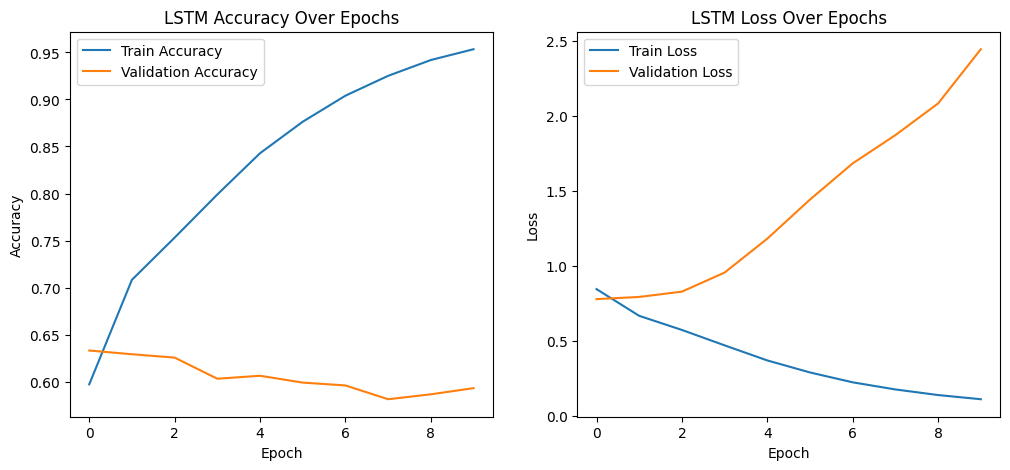

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


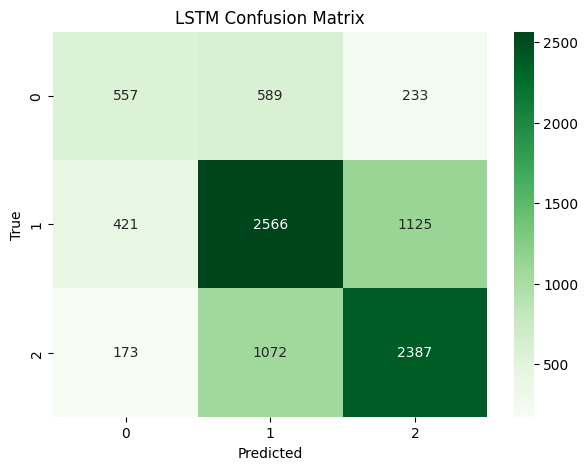

LSTM Classification Report:

              precision    recall  f1-score   support

           0     0.4839    0.4039    0.4403      1379
           1     0.6070    0.6240    0.6154      4112
           2     0.6374    0.6572    0.6471      3632

    accuracy                         0.6040      9123
   macro avg     0.5761    0.5617    0.5676      9123
weighted avg     0.6005    0.6040    0.6016      9123



In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Defining the LSTM model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim),
    LSTM(64, return_sequences=False),       # You can also try return_sequences=True with stacked LSTMs
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')          # 3 sentiment classes
])

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Building the model
lstm_model.build(input_shape=(None, max_length))
lstm_model.summary()

# Training  the model
history_lstm = lstm_model.fit(
    X_train_pad, y_train_cat,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Plot Training Curves
plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss curve
plt.subplot(1,2,2)
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Testing the model
y_pred_probs_lstm = lstm_model.predict(X_test_pad)
y_pred_lstm = np.argmax(y_pred_probs_lstm, axis=1)
y_true_lstm = np.argmax(y_test_cat, axis=1)

# Confusion Matrix
conf_mat_lstm = confusion_matrix(y_true_lstm, y_pred_lstm)

plt.figure(figsize=(7,5))
sns.heatmap(conf_mat_lstm, annot=True, fmt='d', cmap='Greens')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("LSTM Classification Report:\n")
print(classification_report(y_true_lstm, y_pred_lstm, digits=4))

### Comparing Between the 3 Models

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

def evaluate_model(model, X_test, y_test_cat, model_name):
    y_probs = model.predict(X_test)
    y_pred = np.argmax(y_probs, axis=1)
    y_true = np.argmax(y_test_cat, axis=1)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f" {model_name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred, digits=4))
    print("-" * 60)

# Evaluate each model
evaluate_model(rnn_model, X_test_pad, y_test_cat, "RNN")
evaluate_model(ffnn_model, X_test_pad, y_test_cat, "Feedforward Neural Network")
evaluate_model(lstm_model, X_test_pad, y_test_cat, "LSTM")

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
 RNN Results:
Accuracy: 0.5592
F1 Score: 0.5572
Classification Report:
              precision    recall  f1-score   support

           0     0.4197    0.3713    0.3940      1379
           1     0.5745    0.5610    0.5677      4112
           2     0.5873    0.6286    0.6073      3632

    accuracy                         0.5592      9123
   macro avg     0.5272    0.5203    0.5230      9123
weighted avg     0.5562    0.5592    0.5572      9123

------------------------------------------------------------
286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
 Feedforward Neural Network Results:
Accuracy: 0.5823
F1 Score: 0.5813
Classification Report:
              precision    recall  f1-score   support

           0     0.4270    0.3967    0.4113      1379
           1     0.5901    0.6175    0.6034      4112
           2     0.6290    0.6129    0.6208      3632

    accuracy                         0.5823      9123
   macro avg     0.5487    0.5423    0.

# Part 2 : Trials to Improve Performance

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-04-30 16:15:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-30 16:15:47--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-30 16:15:47--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
import numpy as np

# Load GloVe vectors (adjust path based on your file)
def load_glove_embeddings(file_path):
    embeddings_index = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Example: Load the 100d GloVe embeddings
embedding_dim = 100
glove_file = 'glove.6B.100d.txt'  # Path to the 100d GloVe file
embeddings_index = load_glove_embeddings(glove_file)

print(f"Loaded {len(embeddings_index)} word vectors.")


Loaded 400000 word vectors.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Fit a Tokenizer on your training data
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # X_train is your training text data

vocab_size = min(len(tokenizer.word_index) + 1, 10000)  # Limit vocab size

# Create the embedding matrix
def create_embedding_matrix(tokenizer, embeddings_index, vocab_size, embedding_dim):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, index in tokenizer.word_index.items():
        if index < vocab_size:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
    return embedding_matrix

# Create the embedding matrix
embedding_matrix = create_embedding_matrix(tokenizer, embeddings_index, vocab_size, embedding_dim)


### Trial 2 : Bidirectional RNN with dropout and early stopping.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping

# Define the model with pretrained embeddings
rnn_model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,
              weights=[embedding_matrix],  # Use GloVe embeddings
              trainable=False),  # Optionally freeze the embeddings
    Bidirectional(SimpleRNN(64, return_sequences=False)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Compile the model
rnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print the model summary
rnn_model.summary()


# Define early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = rnn_model.fit(
    X_train_pad, y_train_cat,  # Make sure your input data is padded (X_train_pad)
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stop]
)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - accuracy: 0.4747 - loss: 1.0169 - val_accuracy: 0.5794 - val_loss: 0.8668
Epoch 2/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.5802 - loss: 0.8696 - val_accuracy: 0.5901 - val_loss: 0.8479
Epoch 3/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5971 - loss: 0.8431 - val_accuracy: 0.5965 - val_loss: 0.8387
Epoch 4/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.6090 - loss: 0.8304 - val_accuracy: 0.5649 - val_loss: 0.8850
Epoch 5/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.6084 - loss: 0.8256 - val_accuracy: 0.5987 - val_loss: 0.8298
Epoch 6/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.6270 - loss: 0.7968 - val_accuracy: 0.5994 - val_loss: 0.8330
Epoch 7/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6281 - loss: 0.7915 - val_accuracy: 0.6161 - val_loss: 0.8276
Epoch 8/10
913/913 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.6436 - loss: 0.7648 - val_acc

### Seeing the Differnece

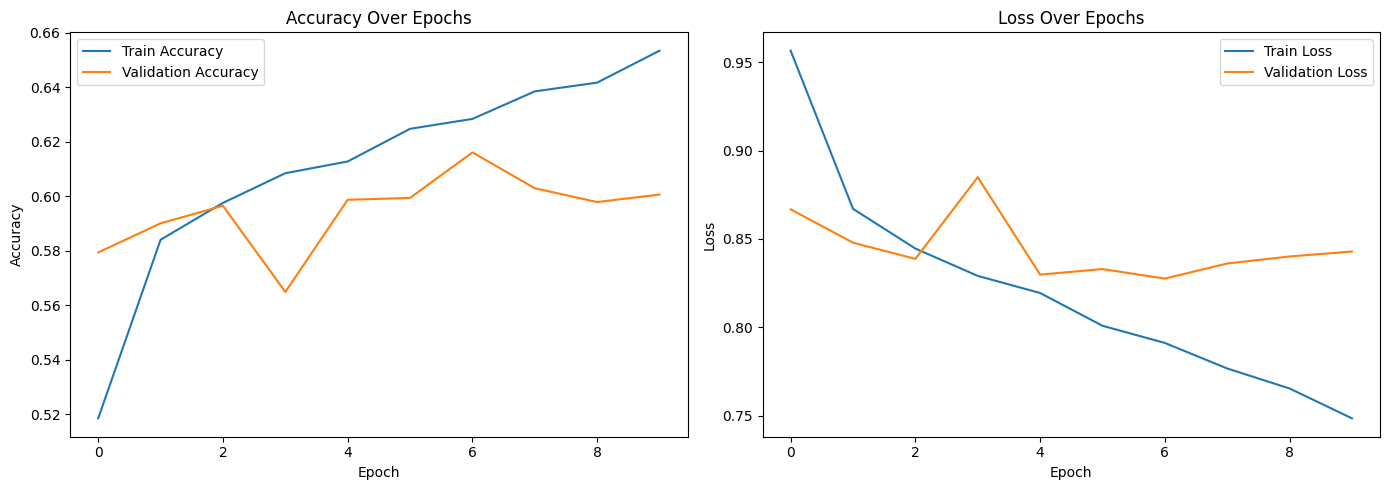

286/286 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


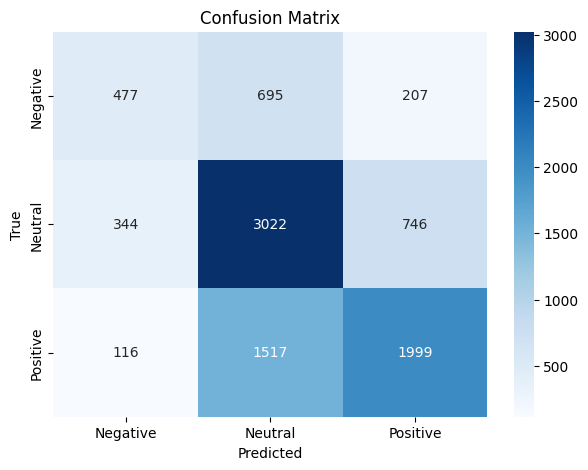

Classification Report:
              precision    recall  f1-score   support

    Negative     0.5091    0.3459    0.4119      1379
     Neutral     0.5774    0.7349    0.6467      4112
    Positive     0.6772    0.5504    0.6072      3632

    accuracy                         0.6027      9123
   macro avg     0.5879    0.5437    0.5553      9123
weighted avg     0.6068    0.6027    0.5955      9123



In [ ]:
# Plot accuracy and loss curves
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
y_pred_probs = rnn_model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, digits=4, target_names=['Negative', 'Neutral', 'Positive']))


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Define the LSTM model
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=max_length,  # Adjust based on your padding length
              weights=[embedding_matrix],  # Use GloVe embeddings
              trainable=False),  # Optionally freeze the embeddings
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(3, activation='softmax')  # 3 sentiment classes
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [ ]:
# Train the model
history = model.fit(
    X_train_pad, y_train_cat,  # Ensure your text is padded and labels are one-hot encoded
    epochs=12,
    batch_size=64,
    validation_split=0.2,
    verbose=1
)


Epoch 1/12
457/457 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.5292 - loss: 0.9369 - val_accuracy: 0.6109 - val_loss: 0.8229
Epoch 2/12
457/457 ━━━━━━━━━━━━━━━━━━━━ 23s 51ms/step - accuracy: 0.6114 - loss: 0.8209 - val_accuracy: 0.6205 - val_loss: 0.7936
Epoch 3/12
457/457 ━━━━━━━━━━━━━━━━━━━━ 38s 46ms/step - accuracy: 0.6390 - loss: 0.7845 - val_accuracy: 0.6275 - val_loss: 0.7828
Epoch 4/12
457/457 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.6501 - loss: 0.7659 - val_accuracy: 0.6341 - val_loss: 0.7818
Epoch 5/12
457/457 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.6675 - loss: 0.7457 - val_accuracy: 0.6347 - val_loss: 0.7816
Epoch 6/12
457/457 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.6833 - loss: 0.7153 - val_accuracy: 0.6283 - val_loss: 0.7862
Epoch 7/12
457/457 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.7021 - loss: 0.6894 - val_accuracy: 0.6312 - val_loss: 0.7830
Epoch 8/12
457/457 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.7057 - loss: 0.6676 - 

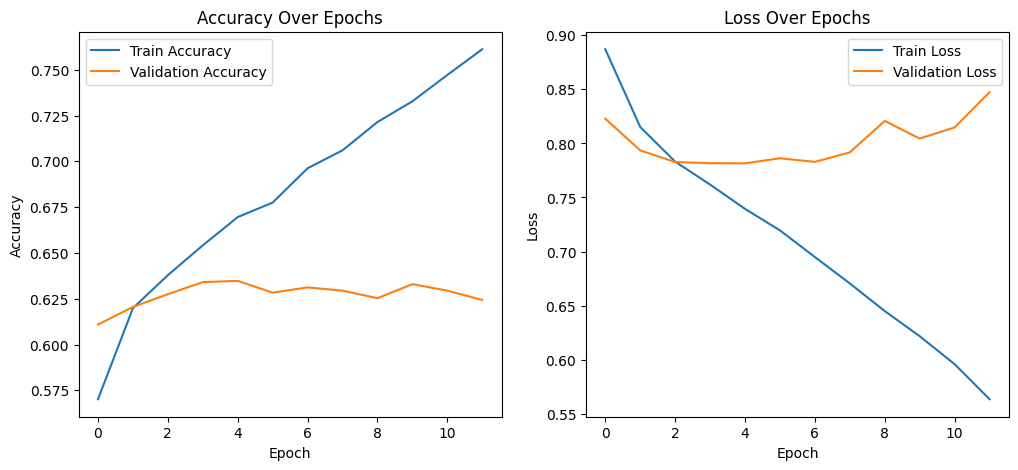

In [ ]:
# Plotting Training Curves
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


286/286 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step


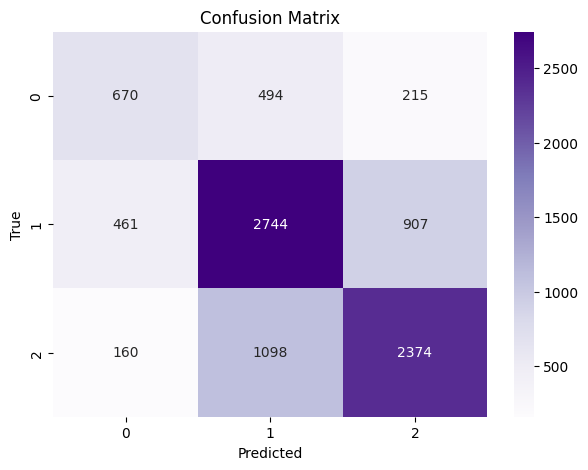

Classification Report:

              precision    recall  f1-score   support

           0     0.5190    0.4859    0.5019      1379
           1     0.6328    0.6673    0.6496      4112
           2     0.6791    0.6536    0.6661      3632

    accuracy                         0.6344      9123
   macro avg     0.6103    0.6023    0.6059      9123
weighted avg     0.6340    0.6344    0.6339      9123



In [ ]:
# Predictions
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Purples')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, digits=4))
